In [1]:
import numpy as np 
import pandas as pd
from scipy import stats as stats
from scipy.stats import norm

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.linear_model import Ridge, Lasso
from sklearn import svm


import xgboost as xgb

import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#loading data
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


### Apply actions

Apply following actions:

See `2-0-house_price_data_exploration_nans.ipynb`
1. Remove FireplaceQu, Fence, Alley, MiscFeature, PoolQC (Too many NaNs).

See `2-1-house_price_data_exploration_dependent_variable.ipynb`
2. Apply a log transformation to the dependent variable SalePrice.

See `2-2-house_price_data_exploration_dependent_vars.ipynb`
3. Remove outlier id 1299, 524
4. Apply log transformations to 1stFlrSF.
5. Apply log + 1 transformations to TotalBsmtSF, GarageArea (Has a lot of zero values, thus "+ 1")

In [3]:
# Remove FireplaceQu, Fence, Alley, MiscFeature, PoolQC (Too many NaNs).
del train['FireplaceQu']
del train['Fence']
del train['Alley']
del train['MiscFeature']
del train['PoolQC']
del test['FireplaceQu']
del test['Fence']
del test['Alley']
del test['MiscFeature']
del test['PoolQC']

print(train.shape)
print(test.shape)

(1460, 76)
(1459, 75)


In [4]:
# Apply a log transformation to the dependent variable SalePrice.
train['SalePrice'] = np.log(train['SalePrice'])

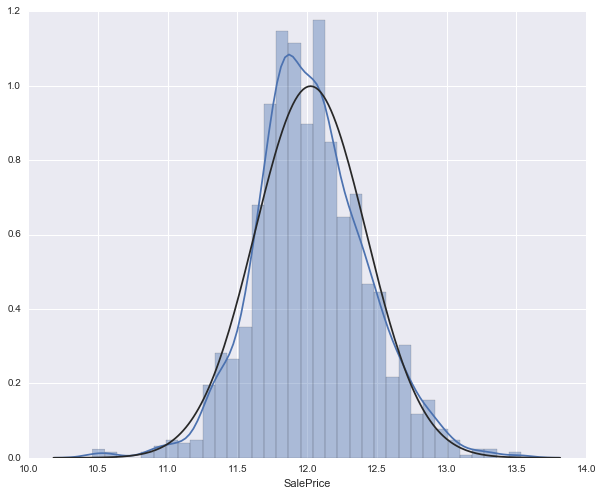

In [5]:
# Sanity check
sns.distplot(train['SalePrice'], fit=norm)

In [6]:
# Remove outlier id 1299, 524
train = train.drop(train[train.Id==1299].index)
train = train.drop(train[train.Id==524].index)

#4. Apply log transformations to 1stFlrSF.
#5. Apply log + 1 transformations to TotalBsmtSF, GarageArea (Has a lot of zero values, thus "+ 1")

In [7]:
# Apply log transformations to 1stFlrSF.
train['1stFlrSF'] = np.log(train['1stFlrSF'])
test['1stFlrSF'] = np.log(test['1stFlrSF'])

In [8]:
# Apply log + 1 transformations to TotalBsmtSF, GarageArea (Has a lot of zero values, thus "+ 1")
train['TotalBsmtSF'] = np.log1p(train['TotalBsmtSF'])
train['GarageArea '] = np.log1p(train['GarageArea'])
test['TotalBsmtSF'] = np.log1p(test['TotalBsmtSF'])
test['GarageArea '] = np.log1p(test['GarageArea'])

### Handle missing data by naively fillna as 0.

In [9]:
### Handle missing data by naively fillna as 0.
miss = train.isnull().mean()
miss = miss[miss > 0]
miss.sort_values(inplace=True)
na_exist = miss.index

In [10]:
for na in na_exist:
    train[na].fillna(0, inplace=True)

In [11]:
# Confirm that Nans have been handled
miss = train.isnull().mean()
miss = miss[miss > 0]
miss.sort_values(inplace=True)
na_exist = miss.index
na_exist

Index([], dtype='object')

In [12]:
# Apply same process to test data
miss = test.isnull().mean()
miss = miss[miss > 0]
miss.sort_values(inplace=True)
na_exist = miss.index

for na in na_exist:
    test[na].fillna(0, inplace=True)
    
# Confirm that Nans have been handled
miss = test.isnull().mean()
miss = miss[miss > 0]
miss.sort_values(inplace=True)
na_exist = miss.index
na_exist

Index([], dtype='object')

In [13]:
print(train.shape)
print(test.shape)
train.head()

(1458, 77)
(1459, 76)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,GarageArea
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2,2008,WD,Normal,12.247694,6.308098
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,5,2007,WD,Normal,12.109011,6.133398
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,9,2008,WD,Normal,12.317167,6.411818
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,2,2006,WD,Abnorml,11.849398,6.466145
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,12,2008,WD,Normal,12.429216,6.729824


### Convert categorical variables to one hot vectors

In [14]:
# Naively apply get_dummies
train = pd.get_dummies(train)
test = pd.get_dummies(test)
print(train.shape)
print(test.shape)

(1458, 283)
(1459, 273)


In [15]:
# We have created train features not found in test and features in test not found in training.
train_remove = []
test_remove = []

for tr in train.columns:
    found = False
    for te in test.columns:
        if te == tr:
            found = True
    if not found:
        train_remove.append(tr)
        
for te in test.columns:
    found = False
    for tr in train.columns:
        if te == tr:
            found = True
    if not found:
        test_remove.append(te)
        
print(train_remove)
print(test_remove)

['SalePrice', 'Utilities_NoSeWa', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'HouseStyle_2.5Fin', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior2nd_Other', 'Heating_Floor', 'Heating_OthW', 'Electrical_0', 'Electrical_Mix', 'GarageQual_Ex']
['MSZoning_0', 'Utilities_0', 'Exterior1st_0', 'Exterior2nd_0', 'KitchenQual_0', 'Functional_0', 'SaleType_0']


In [16]:
for feature in train_remove:
    if feature != 'SalePrice':
        del train[feature]

for feature in test_remove:
    del test[feature]

In [17]:
print(train.shape)
print(test.shape)
train.head()

(1458, 267)
(1459, 266)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0


In [18]:
#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Drop the  'Id' colum
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# Prepare for training
y = pd.DataFrame(train.pop('SalePrice'))
X = train
X_test = test

In [19]:
# Confirm dimensions make sense
print(X.shape)
print(X_test.shape)
print(y.shape)

(1458, 265)
(1459, 265)
(1458, 1)


In [20]:
# Construct pipelines
pipe_ridge = Pipeline([('scl', StandardScaler()),
            ('pca', PCA()),
            ('regr', Ridge())])

pipe_lasso = Pipeline([('scl', StandardScaler()),
            ('pca', PCA()),
            ('regr', Lasso())])

pipe_xgb = Pipeline([('scl', StandardScaler()),
            ('pca', PCA()),
            ('regr', xgb.XGBRegressor())])

# Parameters to use for grid search
param_ridge = {
    'pca__n_components': (2,3,4),
    'regr__alpha': np.logspace(0,10,10) # alpha >= 0
}

param_lasso = {
    'pca__n_components': (2,3,4),
    'regr__alpha': np.logspace(-10,5,10)
}

param_xgb = {
    'regr__max_depth': range(3,10,2),
    'regr__min_child_weight': range(1,6,2)
}

# Create dictionary for easy referencing
pipe_dict = {
    "ridge": ('Ridge', pipe_ridge, param_ridge),
    "lasso": ('Lasso', pipe_lasso, param_lasso),
    "xgb": ('XGB', pipe_xgb, param_xgb)
}

# For cross validation
regressor = ["ridge", "lasso", "xgb"]
cv =  ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

best_pipe = best_regr = best = None

for regr in regressor:
    model, pipe, param_grid = pipe_dict[regr]
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv)
    grid.fit(X, y)
    
    print("{}: The best parameters are {} with a score of {:0.5f}".format(
          model, grid.best_params_, grid.best_score_)
    )
    

Ridge: The best parameters are {'regr__alpha': 12.915496650148841, 'pca__n_components': 4} with a score of 0.68953
Lasso: The best parameters are {'regr__alpha': 0.021544346900318867, 'pca__n_components': 4} with a score of 0.68983
XGB: The best parameters are {'regr__max_depth': 3, 'regr__min_child_weight': 5} with a score of 0.85979


In [24]:
from sklearn.metrics import mean_squared_error
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))

# Use best parameters from grid search
pipe_ridge = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=4)),
            ('regr', Ridge(alpha=1))])


pipe_ridge.fit(X, y)
y_pred = pipe_ridge.predict(X)
y_test = y
print("Ridge score on training set: ", rmse(y_test, y_pred))


('Ridge score on training set: ', 0.21559286568569327)


In [25]:

# Use best parameters from grid search
pipe_lasso = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=4)),
            ('regr', Lasso(alpha=1e-10))])


pipe_lasso.fit(X, y)
y_pred = pipe_lasso.predict(X)
y_test = y
print("Lasso score on training set: ", rmse(y_test, y_pred))


('Lasso score on training set: ', 0.21559420685049613)


In [26]:

# Use best parameters from grid search
pipe_xgb = Pipeline([('scl', StandardScaler()),
            ('pca', PCA()),
            ('regr', xgb.XGBRegressor(max_depth=3, min_child_weight=5))])

pipe_xgb.fit(X, y)
y_pred = pipe_xgb.predict(X)
y_test = y
print("XGB score on training set: ", rmse(y_test, y_pred))


y_pred_test = pipe_xgb.predict(X_test)
y_pred_test_ex = np.exp(y_pred_test)
pred_submit = pd.DataFrame({'Id': test_ID, 'SalePrice': y_pred_test_ex})
pred_submit.to_csv('xgb_less_naive.csv', header=True, index=False)

('XGB score on training set: ', 0.088049776102246846)
